# Data Cleaning & Preparation

In [3]:
import pandas as pd

df = pd.read_csv("Secondfile.csv")

df.columns = (
    df.columns
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.replace(' ', '_')
    .str.replace('.', '_')
)

df = df.drop(columns=['Radio', 'Other'])

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2016-01-01 to 2015-12-01
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed_0                    12 non-null     int64  
 1   month                        12 non-null     object 
 2   Revenue_Camera               12 non-null     float64
 3   Revenue_CameraAccessory      12 non-null     float64
 4   Revenue_EntertainmentSmall   12 non-null     float64
 5   Revenue_GameCDDVD            12 non-null     float64
 6   Revenue_GamingHardware       12 non-null     float64
 7   total_gmv                    12 non-null     float64
 8   Units_Camera                 12 non-null     int64  
 9   Units_CameraAccessory        12 non-null     int64  
 10  Units_EntertainmentSmall     12 non-null     int64  
 11  Units_GameCDDVD              12 non-null     int64  
 12  Units_GamingHardware         12 non-null     int64  
 13  to

# Feature Selection & Standardization 

In [13]:
from sklearn.preprocessing import StandardScaler

y = df['total_gmv']

media_features = ['TV', 'Digital', 'Sponsorship', 'ContentMarketing',
                  'Onlinemarketing', 'Affiliates', 'SEM']
media_features_with_nps = media_features + ['NPS']

X = df[media_features_with_nps]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=df.index)

print(X_scaled_df.head())


ValueError: Shape of passed values is (12, 8), indices imply (12, 7)

# Bayesian MMM

In [5]:
import pymc as pm
import arviz as az
import numpy as np

X_matrix = X_scaled_df.values
y_vector = y.values
n_features = X_matrix.shape[1]

with pm.Model() as bayesian_mmm:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    coefficients = pm.Normal("coefficients", mu=0, sigma=1, shape=n_features)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = intercept + pm.math.dot(X_matrix, coefficients)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_vector)

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

print(az.summary(trace, var_names=["intercept", "coefficients", "sigma"]))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coefficients, sigma]


/Users/vasukhare/Desktop/Marketing Mix Modeling/venv/lib/python3.13/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


                      mean     sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
intercept          323.862  9.789    305.130    341.670      0.083    0.111   
coefficients[0]      0.840  0.995     -1.069      2.675      0.009    0.011   
coefficients[1]      0.486  1.005     -1.395      2.394      0.009    0.012   
coefficients[2]      0.903  1.013     -0.935      2.852      0.009    0.012   
coefficients[3]      0.761  0.996     -1.114      2.651      0.009    0.013   
coefficients[4]      1.083  0.990     -0.844      2.862      0.008    0.012   
coefficients[5]      1.046  1.006     -0.798      2.962      0.009    0.011   
coefficients[6]      0.663  1.000     -1.222      2.514      0.008    0.013   
sigma            35427.730  0.509  35426.760  35428.657      0.004    0.006   

                 ess_bulk  ess_tail  r_hat  
intercept         13924.0    6447.0    1.0  
coefficients[0]   13004.0    6273.0    1.0  
coefficients[1]   11691.0    5755.0    1.0  
coefficients[2]   11706.0    

# ROI

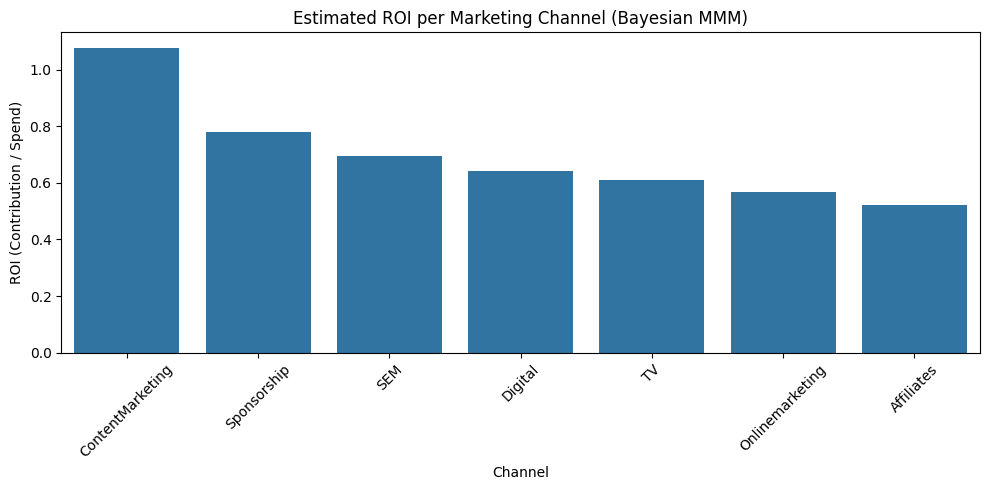

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract posterior means
posterior_means = trace.posterior['coefficients'].mean(dim=["chain", "draw"]).values

# Mean and std from original data
media_spend = X.mean()
media_std = X.std()

# Contribution = posterior mean × std(media_spend)
channel_contrib = posterior_means * media_std

# ROI = Contribution / Mean Spend
roi = channel_contrib / media_spend

# Build ROI DataFrame
roi_df = pd.DataFrame({
    "Channel": media_features,
    "Posterior_Mean": posterior_means,
    "Avg_Spend": media_spend.values,
    "Estimated_Contribution": channel_contrib,
    "ROI": roi
}).sort_values(by="ROI", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=roi_df, x='Channel', y='ROI')
plt.title("Estimated ROI per Marketing Channel (Bayesian MMM)")
plt.ylabel("ROI (Contribution / Spend)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

